# 0. Completed project

Hi! In order to make the Adversarial Autoencoder (AAE) more modular and user-friendly I created a class that defines it and has many methods related to its usage, such as training, plotting its performance and inferring on data. I'll start this notebook by showing the "final product", defining this class and doing some training/testing.

On the sections that follow I'll then explain how this class was built piece by piece (or method by method, in this case!).

# 1. Making imports

First things first, since I'm using Google Colab to train the model, I have to mount my Google Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


And also import all of the libraries I'm going to use:

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.optim as optim
import copy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
import tarfile
import PIL
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 2. The data

## 2.0 Preparing the data

I cloned [this](https://github.com/zysymu/ML4SCI_GSoC) ML4SCI_GSoC github that I froked from the original. I also changed some files aroung and created a directory called `domain_adaptation`, where this notebook is located and where I have the `Domain Adaptation` containing ML4SCI's evaluation test files.

I extract `lenses.tgz` in order to be able to work with the lens images. The code that does this is commented out because this only needs to happen once.

In [3]:
"""
fname = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/lenses.tgz'
extract_path = '/content/drive/MyDrive/ml4sci/domain_adaptation/'

with tarfile.open(fname, "r:gz") as tar:
    tar.extractall(extract_path)
    tar.close()
"""

'\nfname = \'/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/lenses.tgz\'\nextract_path = \'/content/drive/MyDrive/ml4sci/domain_adaptation/\'\n\nwith tarfile.open(fname, "r:gz") as tar:\n    tar.extractall(extract_path)\n    tar.close()\n'

I then crate a variable that has the path that contains all lens images:

In [4]:
lens_dir = '/content/drive/MyDrive/ml4sci/domain_adaptation/lenses'

I also plot two random images from each category in order to have a better idea of how they look like:

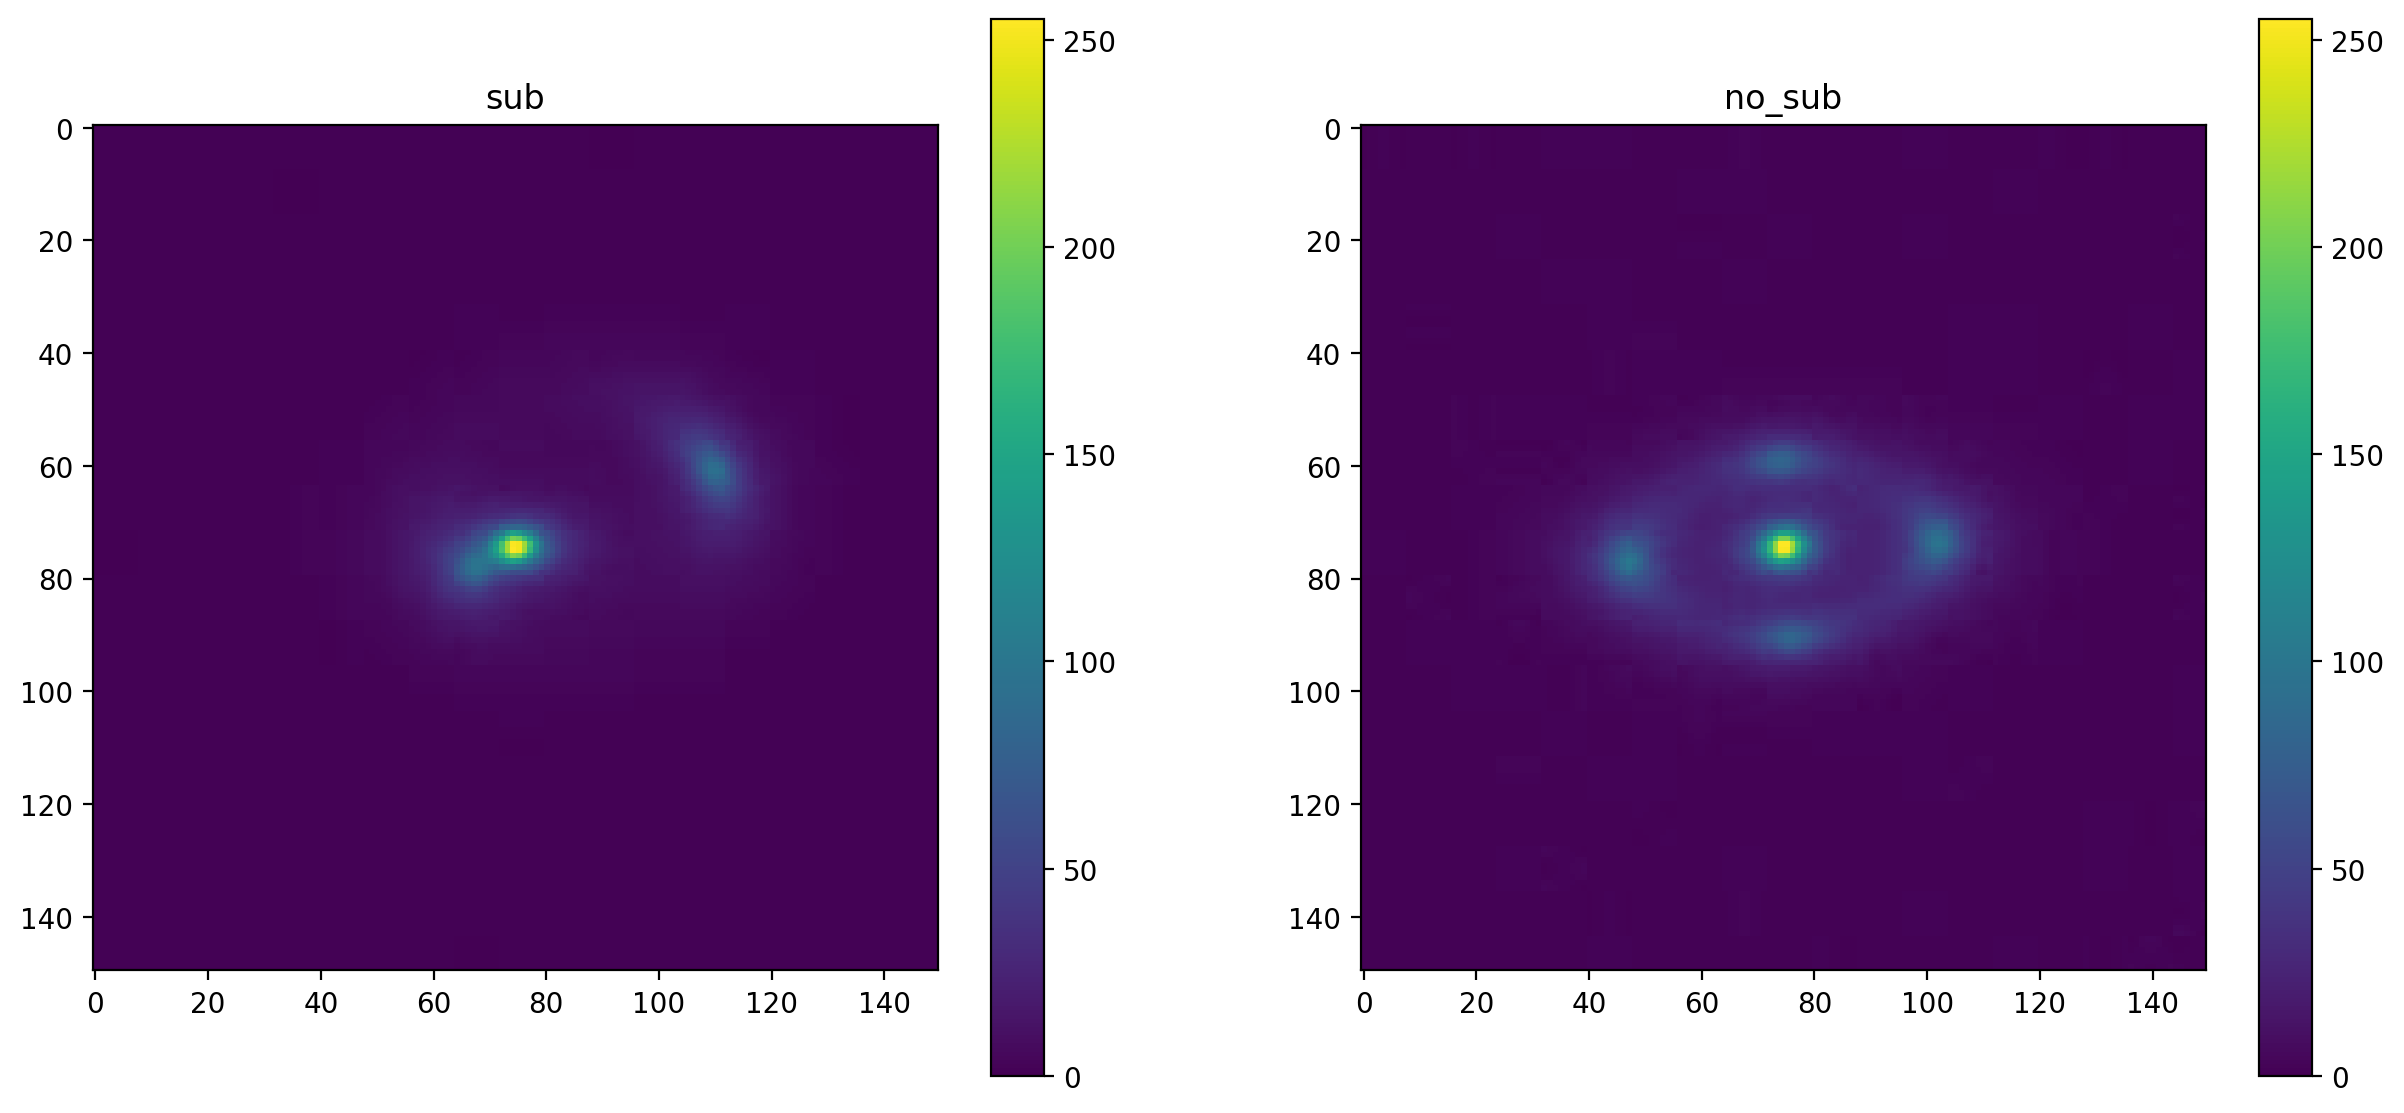

In [5]:
sub_dir = os.path.join(lens_dir, 'sub')
no_sub_dir = os.path.join(lens_dir, 'no_sub')

# pick random images to plot
sub_img = PIL.Image.open(os.path.join(sub_dir,'image_100015241301657914033614173596761104525.jpg'))
no_sub_img = PIL.Image.open(os.path.join(no_sub_dir,'image_97223362218452437755314224058973719256.jpg'))

fig, axs = plt.subplots(1, 2, figsize=(15,7), dpi=200)
im1 = axs[0].imshow(sub_img)
axs[0].set_title('sub')
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(no_sub_img)
axs[1].set_title('no_sub')
plt.colorbar(im2, ax=axs[1])
plt.show()

In order to have a better idea of how the data is distributed, I check how many images are in each category:

In [6]:
print('sub:', len([f for f in os.listdir(sub_dir)]))
print('no_sub:', len([f for f in os.listdir(no_sub_dir)]))

sub: 5000
no_sub: 5000


It's **very** well distribued!

## 2.1 Creating ways to interact with the data

Now we're concerned with creating a way that'll make it possible for our AAE to retrieve this data and use it for both training and testing (inference).

Since our images are neatly packed in sub-directories, I'll make use of PyTorch's `ImageFolder` to create a dataset that contains all images and their labels:

In [7]:
dataset = ImageFolder(lens_dir)

Here is a sample image and its label:

0
(150, 150)


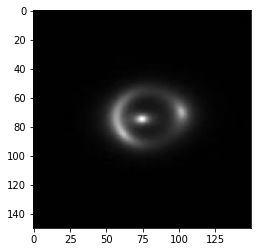

In [8]:
plt.imshow(dataset[0][0])
print(dataset[0][1])
print(dataset[0][0].size)

And here is the map between the label number and the label name. This lets us know that from now on:

- `no_sub` = 0
- `sub` = 1

In [9]:
print(dataset.class_to_idx)

{'no_sub': 0, 'sub': 1}


The next step is to create a more elaborate dataset that lets us apply transforms to the data, among other utilities.

The `LensDataset` clas that we define on the next cell makes it possible for us to turn the image into a grayscale version of itself, which is necessary given. This is necessary because the input to the `Encoder` needs to have only 1 channel (while a .jpg image has 3), as we'll see later on this notebook when we define it. TALVEZ COISA DE NROAMLIZAR PRA -1 E +1????????

The usage of `LensDataset` also makes it really easy to apply data augmentation to the images that'll be used for training, which is especially useful given that there aren't that many images available.


 Define tranforms for data augmentation (data must be normalized between -1 and +1 since the `Decoder`'s last layer has a tanh function) and define the `LensDataset` class to be used for both training and testing:

In [10]:
class LensDataset(Dataset):
    def __init__(self, dataset, phase='train'):
        self.dataset = dataset
        self.phase = phase

    def __getitem__(self, idx):
        if self.phase == 'train':
            transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.RandomRotation(5),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.Resize((150, 150)),
                                            #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                            transforms.Grayscale(num_output_channels=1)
                                            ])
            
            data = transform(dataset[idx][0])
            return data

        elif self.phase == 'eval':
            transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Resize((150, 150)),
                                            #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                            transforms.Grayscale(num_output_channels=1)
                                            ])
            
            data = transform(dataset[idx][0])
            label = dataset[idx][1]
            return data, label

    def __len__(self):
        return len(dataset)

Notice how there are two `phase` possibilities. The `train` phase is one where we output the augmented images to the model; the `eval` phase, on the other hand outputs both the images and their respective labels, which makes it possible for us to evaluate the performance of the AAE.

Were we to create a framework that lets us pass individual images or folders of images to be classified by the AAE, it would be better to restructure `LensDataset` so that it accepts as input a directory path or file path, insred of depending solely on a `dataset` that has `(data, label)` pairs.

## 2.2 Readying the data for training/testing

Following the instructions in the test document, we split the data so that 90% of it is used for training and 10% is used for testing:

In [11]:
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

print('dataset sizes:', len(train_dataset), len(test_dataset))

"""
zeros = 0
ones = 0

for el in test_dataset:
    if el[1] == 0:
        zeros += 1
    else:
        ones += 1

print('counts test:', f'0:{zeros}', f'1:{ones}')
"""

dataset sizes: 9000 1000


"\nzeros = 0\nones = 0\n\nfor el in test_dataset:\n    if el[1] == 0:\n        zeros += 1\n    else:\n        ones += 1\n\nprint('counts test:', f'0:{zeros}', f'1:{ones}')\n"

The code that counts how many instances of each label is in the `test_dataset` was commented out due to taking some time to count all of the instances. But we can conclude that both `no_sub` and `sub` were evenly distributed among the two datasets.

Then, finally, we create two `DataLoader`s, which will be used for training the data. The `BATCH_SIZE` hyperparameter is arbitrarily chosen to be 64.

In [12]:
BATCH_SIZE = 64

train_dataset = LensDataset(train_dataset, 'train')
test_dataset = LensDataset(test_dataset, 'eval')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 3. The AAE

As explained at the start of the notebook, the AAE will be defined as a class and be used for training directly with this class structure. The methods that make up this class will be discussed with more detail later on the notebook.

## 3.0 Defining the AAE architecture

Since the pre-trained models were saved with their architecture and weights, I first need to define the AAE according to `AAE_Network_Architecture.py`:

In [13]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 7, stride=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 7, stride=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(5184, 1000)

    def forward(self, x):

        convolution1 = F.relu(self.conv1(x))
        convolution2 = F.relu(self.conv2(convolution1))
        convolution3 = F.relu(self.conv3(convolution2))
        Flattened = self.flat(convolution3)
        z = self.linear(Flattened)

        return z

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(1000, 5184)
        self.conv4 = nn.ConvTranspose2d(64, 32, 7)
        self.conv5 = nn.ConvTranspose2d(32, 16, 7, stride=3, padding=1, output_padding=2)
        self.conv6 = nn.ConvTranspose2d(16, 1, 6, stride=3, padding=1, output_padding=2)

    def forward(self, x):

        hidden = self.linear(x)
        Reshaped = hidden.reshape(-1,64,9,9)
        convolution4 = F.relu(self.conv4(Reshaped))
        convolution5 = F.relu(self.conv5(convolution4))
        predicted = torch.tanh(self.conv6(convolution5))

        return predicted

class Discriminator(nn.Module):

    def __init__(self, dim_z=1000 , dim_h=256):
        super(Discriminator,self).__init__()
        self.dim_z = dim_z
        self.dim_h = dim_h
        self.network = []
        self.network.extend([
            nn.Linear(self.dim_z, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h,1),
            nn.Sigmoid(),
        ])
        self.network = nn.Sequential(*self.network)

    def forward(self, z):
        disc = self.network(z)
        return disc


## 3.1 Creating the `UnsupervisedAAE` class

In [14]:
class UnsupervisedAAE(object):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    def __init__(self):
        """
        Instanciates the models without prior training
        """
        print('using device:', UnsupervisedAAE.device)

        encoder = Encoder()
        decoder = Decoder()
        discriminator = Discriminator()

        self.encoder = encoder.to(UnsupervisedAAE.device)
        self.decoder = decoder.to(UnsupervisedAAE.device)
        self.discriminator = discriminator.to(UnsupervisedAAE.device)

    def load_model(self, encoder_model, decoder_model, discriminator_model):
        """
        Loads the model by being given the path to the architecture + weights of each network
        """
        encoder = torch.load(encoder_model, map_location=UnsupervisedAAE.device)
        decoder = torch.load(decoder_model, map_location=UnsupervisedAAE.device)
        discriminator = torch.load(discriminator_model, map_location=UnsupervisedAAE.device)

        self.encoder = encoder.to(UnsupervisedAAE.device)
        self.decoder = decoder.to(UnsupervisedAAE.device)
        self.discriminator = discriminator.to(UnsupervisedAAE.device)

    def load_weights_and_history(self, save_path):
        """
        Loads the model weights by being given the path to the weights of each network
        """
        s = torch.load(save_path)#, map_location=UnsupervisedAAE.device)

        self.history = s['history']

        self.encoder.load_state_dict(s['encoder_weights'])
        self.decoder.load_state_dict(s['decoder_weights'])
        self.discriminator.load_state_dict(s['discriminator_weights'])

        self.encoder = self.encoder.to(UnsupervisedAAE.device)
        self.decoder = self.decoder.to(UnsupervisedAAE.device)
        self.discriminator = self.discriminator.to(UnsupervisedAAE.device)

    def train(self, train_dataloader, epochs, save_path):
        """
        Train the AAE.

        Inputs:
        -------
        train_dataloader: a `DataLoader` based on a `LensDataset`

        epochs: number of epochs to train on (int)

        save_path: path to save the model's weights and history (str)
        """
        # --- HYPERPARAMETERS --- (this could be made into a single method where you can input the desired hyperparams)
        # reconstruction phase:
        reconstruction_criterion = nn.MSELoss()
        encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=1e-4)
        decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=1e-4)

        # regularization phase:
        def discriminator_criterion(input, target, epsilon):
            return -torch.mean(torch.log(target + epsilon) + torch.log(1 - input + epsilon))

        def generator_criterion(input, epsilon):
            return -torch.mean(torch.log(input + epsilon))

        discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=1e-4)
        generator_optimizer = optim.Adam(self.encoder.parameters(), lr=1e-5)

        # --- HISOTRY ---
        history = {'reconstruction_losses': [],
                   'discriminator_losses': [],
                   'generator_losses': []}

        # --- TRAINING LOOP ---
        epsilon = 1e-10 # prevents the loss from getting to zero

        reconstruction_losses = []
        discriminator_losses = []
        generator_losses = []

        for epoch in range(epochs):
            self.decoder.train()
            self.encoder.train()
            self.discriminator.train()

            running_reconstruction_loss = 0.0
            running_discriminator_loss = 0.0
            running_generator_loss = 0.0

            loop = tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True)
            for data in loop:
                data = data.to(UnsupervisedAAE.device)

                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                discriminator_optimizer.zero_grad()
                generator_optimizer.zero_grad()

                # RECONSTRUCTION PHASE
                # pass data through the autoencoder
                z_sample = self.encoder(data)
                x_sample = self.decoder(z_sample)

                # compute the loss
                reconstruction_loss = reconstruction_criterion(input=x_sample, target=data)
                
                # backpropagate and update weights
                reconstruction_loss.backward()
                decoder_optimizer.step()
                encoder_optimizer.step()

                # REGULARIZATION PHASE - DISCRIMINATOR
                self.encoder.eval()
                
                # generate target latent space data according to a gaussian distribution
                z_real_gauss = Variable(torch.randn(data.size(0), 1000) * 5.) # 1000 fixed cuz its the encoder's input size
                z_real_gauss = z_real_gauss.to(UnsupervisedAAE.device) # what we want
                z_fake_gauss = self.encoder(data) # what we currently have

                # determine discriminator classification of both samples
                d_real_gauss = self.discriminator(z_real_gauss) # real sampled gaussian 
                d_fake_gauss = self.discriminator(z_fake_gauss) # fake created gaussian

                # compute the loss
                discriminator_loss = discriminator_criterion(input=d_fake_gauss, target=d_real_gauss, epsilon=epsilon)
                
                # backpropagate and update weights
                discriminator_loss.backward()
                discriminator_optimizer.step()

                # REGULARIZATION PHASE - GENERATOR
                self.encoder.train()

                z_fake_gauss = self.encoder(data)
                d_fake_gauss = self.discriminator(z_fake_gauss)
                
                # compute the loss
                generator_loss = generator_criterion(input=d_fake_gauss, epsilon=epsilon)

                # backpropagate and update weights
                generator_loss.backward()
                generator_optimizer.step()

                # STATS
                running_reconstruction_loss += reconstruction_loss.item() * data.size(0)
                running_discriminator_loss += discriminator_loss.item() * data.size(0)
                running_generator_loss += generator_loss.item() * data.size(0)

                loop.set_description(f'Epoch {epoch+1}/{epochs}')

            epoch_reconstruction_loss = running_reconstruction_loss / len(train_dataloader.dataset)
            epoch_discriminator_loss = running_discriminator_loss / len(train_dataloader.dataset)
            epoch_generator_loss = running_generator_loss / len(train_dataloader.dataset)

            reconstruction_losses.append(epoch_reconstruction_loss)
            discriminator_losses.append(epoch_discriminator_loss)
            generator_losses.append(epoch_generator_loss)

            print(f'\n[Epoch {epoch+1}/{epochs}]', 'reconstruction loss: {:.4f}; discriminator loss: {:.4f}; generator loss: {:.4f}'.format(epoch_reconstruction_loss, epoch_discriminator_loss, epoch_generator_loss))

        history['reconstruction_losses'] = reconstruction_losses
        history['discriminator_losses'] = discriminator_losses
        history['generator_losses'] = generator_losses

        torch.save({'encoder_weights': self.encoder.state_dict(),
                    'decoder_weights': self.decoder.state_dict(),
                    'discriminator_weights': self.discriminator.state_dict(),
                    'history': history}, save_path)
        
        self.history = history
        
    def metrics(self):
        """
        Plot the three metrics that are tracked during training.
        """
        fig, axs = plt.subplots(1, 3, figsize=(18,5), dpi=200)

        epochs = len(self.history['reconstruction_losses'])

        axs[0].plot(range(1, epochs+1), self.history['reconstruction_losses'])
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Reconstruction loss')
        axs[0].set_title('Reconstruction loss')

        axs[1].plot(range(1, epochs+1), self.history['discriminator_losses'])
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Discriminator loss')
        axs[1].set_title('Discriminator loss')

        axs[2].plot(range(1, epochs+1), self.history['generator_losses'])
        axs[2].set_xlabel('Epochs')
        axs[2].set_ylabel('Generator loss')
        axs[2].set_title('Generator loss')      
        
        plt.show()

    def evaluate(self, test_dataloader, thresh, find_thresh):
        """
        Use the AAE for inference over the `test_dataloader` data. A label is assigned 
        depending on whether the anomaly_score, defined as the error between the original
        image and its reconstruction, is above or below `thresh`.

        Inputs:
        -------
        test_dataloader: a `DataLoader` based on a `LensDataset`

        thresh: a number that defines the label of an input image according to the error
        between the original image and its reconstruction. If error > thresh, label = 1; 
        if error <= thresh, label = 0 (float)

        find_thresh: prints statistics related to the error scores. The mean of the
        mean error for each label is then used to obtain the value for `thresh` (bool)
        """
        self.encoder.eval()
        self.decoder.eval()
        self.discriminator.eval()

        anomaly_scores = {0:[], 1:[]}
        mse = nn.MSELoss()

        if find_thresh:
            print('\nfinding anomaly_scores statistics... use this to define `thresh`!')
            loop = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=True)
            for data, label in loop:
                data = data.to(UnsupervisedAAE.device)
                label = label.to(UnsupervisedAAE.device)

                G = self.encoder(data)
                #D = self.discriminator(G)
                D = self.decoder(G)

                for i in range(data.shape[0]):
                    #anomaly_score = torch.norm(data[0] - D[0])
                    anomaly_score = mse(data[0], D[0])
                    
                    if label[i] == 0:
                        anomaly_scores[0].append(anomaly_score.cpu().item())
                    else:
                        anomaly_scores[1].append(anomaly_score.cpu().item())

            print('\nLABEL 0:', 'min:', min(anomaly_scores[0]), 'max:', max(anomaly_scores[0]), 'mean:', np.mean(anomaly_scores[0]))
            print('\nLABEL 1:', 'min:', min(anomaly_scores[1]), 'max:', max(anomaly_scores[1]), 'mean:', np.mean(anomaly_scores[1]))

            thresh = (np.mean(anomaly_scores[0]) + np.mean(anomaly_scores[1])) / 2
        
        print(f'\nevaluating with thresh={thresh}...')
        predictions = []
        labels = []
        
        loop = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=True)
        for data, label in loop:
            data = data.to(UnsupervisedAAE.device)
            label = label.to(UnsupervisedAAE.device)

            G = self.encoder(data)
            D = self.decoder(G)

            for i in range(data.shape[0]):
                anomaly_score = mse(data[0], D[0])
                
                if anomaly_score <= thresh:
                    predictions.append(0)
                    labels.append(label[i].cpu().item())

                else:
                    predictions.append(1)
                    labels.append(label[i].cpu().item())

        plt.figure(figsize=(7,7), dpi=200)
        fp, tp, _ = roc_curve(labels, predictions)
        auroc = auc(fp, tp)

        auroc = float('{:.2f}'.format(auroc))
        n = f'auroc = {auroc}'

        plt.plot(fp, tp, label=n)
        plt.xlabel('False Positives')
        plt.ylabel('True Positives')
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.legend()
        plt.show()

## 3.2 Training `UnsupervisedAAE`

We'll train the AAE starting with the weights that were given by ML4SCI. 

To do this, we first instantiate the model with `UnsupervisedAAE()`. In order to then load the weights we call the `load_model` method, passing as arguments the path for the weights of each network. Then, to train `UnsupervisedAAE` we just need to call the `train` method, passing as arguments the `train_dataloader` defined earlier, the number of epochs and a path to where the `UnsupervisedAAE` weights (and metrics) are going to be stored.

It's important to note that using `UnsupervisedAAE` we could also train a model from scratch. To do that, we'd just need to comment out the `load_model` line!

In [15]:
encoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Encoder.pth'
decoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Decoder.pth'
discriminator_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Discriminator.pth'

save_path = os.path.join('/content/drive/MyDrive/ml4sci/domain_adaptation/', 'weights_history.pt')

aae = UnsupervisedAAE()
aae.load_model(encoder_weights, decoder_weights, discriminator_weights)
aae.train(train_dataloader, 30, save_path)

using device: cuda:0


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.flatten.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.


[Epoch 1/30] reconstruction loss: 0.0008; discriminator loss: 0.0000; generator loss: 23.0256


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 2/30] reconstruction loss: 0.0001; discriminator loss: 0.0000; generator loss: 22.9361


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 3/30] reconstruction loss: 0.0001; discriminator loss: 0.0007; generator loss: 22.8566


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 4/30] reconstruction loss: 0.0001; discriminator loss: 0.0023; generator loss: 22.6057


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 5/30] reconstruction loss: 0.0001; discriminator loss: 0.0159; generator loss: 22.8453


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 6/30] reconstruction loss: 0.0000; discriminator loss: 0.0342; generator loss: 20.6079


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 7/30] reconstruction loss: 0.0000; discriminator loss: 0.0294; generator loss: 17.3325


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 8/30] reconstruction loss: 0.0000; discriminator loss: 0.0237; generator loss: 14.4242


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 9/30] reconstruction loss: 0.0000; discriminator loss: 0.0218; generator loss: 12.6201


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 10/30] reconstruction loss: 0.0000; discriminator loss: 0.0086; generator loss: 11.4126


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 11/30] reconstruction loss: 0.0000; discriminator loss: 0.0152; generator loss: 11.0205


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 12/30] reconstruction loss: 0.0000; discriminator loss: 0.0131; generator loss: 10.8433


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 13/30] reconstruction loss: 0.0000; discriminator loss: 0.0151; generator loss: 11.1644


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 14/30] reconstruction loss: 0.0000; discriminator loss: 0.0148; generator loss: 15.0068


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 15/30] reconstruction loss: 0.0000; discriminator loss: 0.0208; generator loss: 16.3345


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 16/30] reconstruction loss: 0.0000; discriminator loss: 0.0229; generator loss: 14.2380


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 17/30] reconstruction loss: 0.0000; discriminator loss: 0.0257; generator loss: 12.8320


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 18/30] reconstruction loss: 0.0000; discriminator loss: 0.0353; generator loss: 11.8553


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 19/30] reconstruction loss: 0.0000; discriminator loss: 0.0203; generator loss: 10.4706


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 20/30] reconstruction loss: 0.0000; discriminator loss: 0.0238; generator loss: 9.9030


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 21/30] reconstruction loss: 0.0000; discriminator loss: 0.0144; generator loss: 10.2192


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 22/30] reconstruction loss: 0.0000; discriminator loss: 0.0196; generator loss: 10.5950


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 23/30] reconstruction loss: 0.0000; discriminator loss: 0.0314; generator loss: 14.3178


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 24/30] reconstruction loss: 0.0000; discriminator loss: 0.0277; generator loss: 21.1997


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 25/30] reconstruction loss: 0.0000; discriminator loss: 0.0188; generator loss: 17.5128


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 26/30] reconstruction loss: 0.0000; discriminator loss: 0.0230; generator loss: 16.7981


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 27/30] reconstruction loss: 0.0000; discriminator loss: 0.0283; generator loss: 15.1310


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 28/30] reconstruction loss: 0.0000; discriminator loss: 0.0149; generator loss: 12.9625


  0%|          | 0/157 [00:00<?, ?it/s]


[Epoch 29/30] reconstruction loss: 0.0000; discriminator loss: 0.0279; generator loss: 10.7699


Epoch 30/30: 100%|██████████| 157/157 [00:40<00:00,  3.90it/s]



[Epoch 30/30] reconstruction loss: 0.0000; discriminator loss: 0.0126; generator loss: 10.3128


## 3.3 Metrics `UnsupervisedAAE`

If we want to plot the metrics that are tracked during training, we just need to call the `metrics` method. This will automatically plot the reconstruction loss, the discriminator loss and the generator loss.

If we want to load the `UnsupervisedAAE` after training we can call the `load_weights_and_history`. This model is the one that should be used for loading the model after training. The rason for that is that when we save the model at the end of the `train` method, we save only the `state_dicts` of each network (as well as the history of the metrics). With `load_weights_and_history` we'll then reload the model by loading its `state_dicts`, which is compliant with PyTorch's best practices.

As a bonus, we can also load the `history` variable, which stores the metrics for the model. With some small manipulation a technique similar to this can be used to train the model using checkpoints, restarting training from where the model stopped, while still keeping track of the metrics!

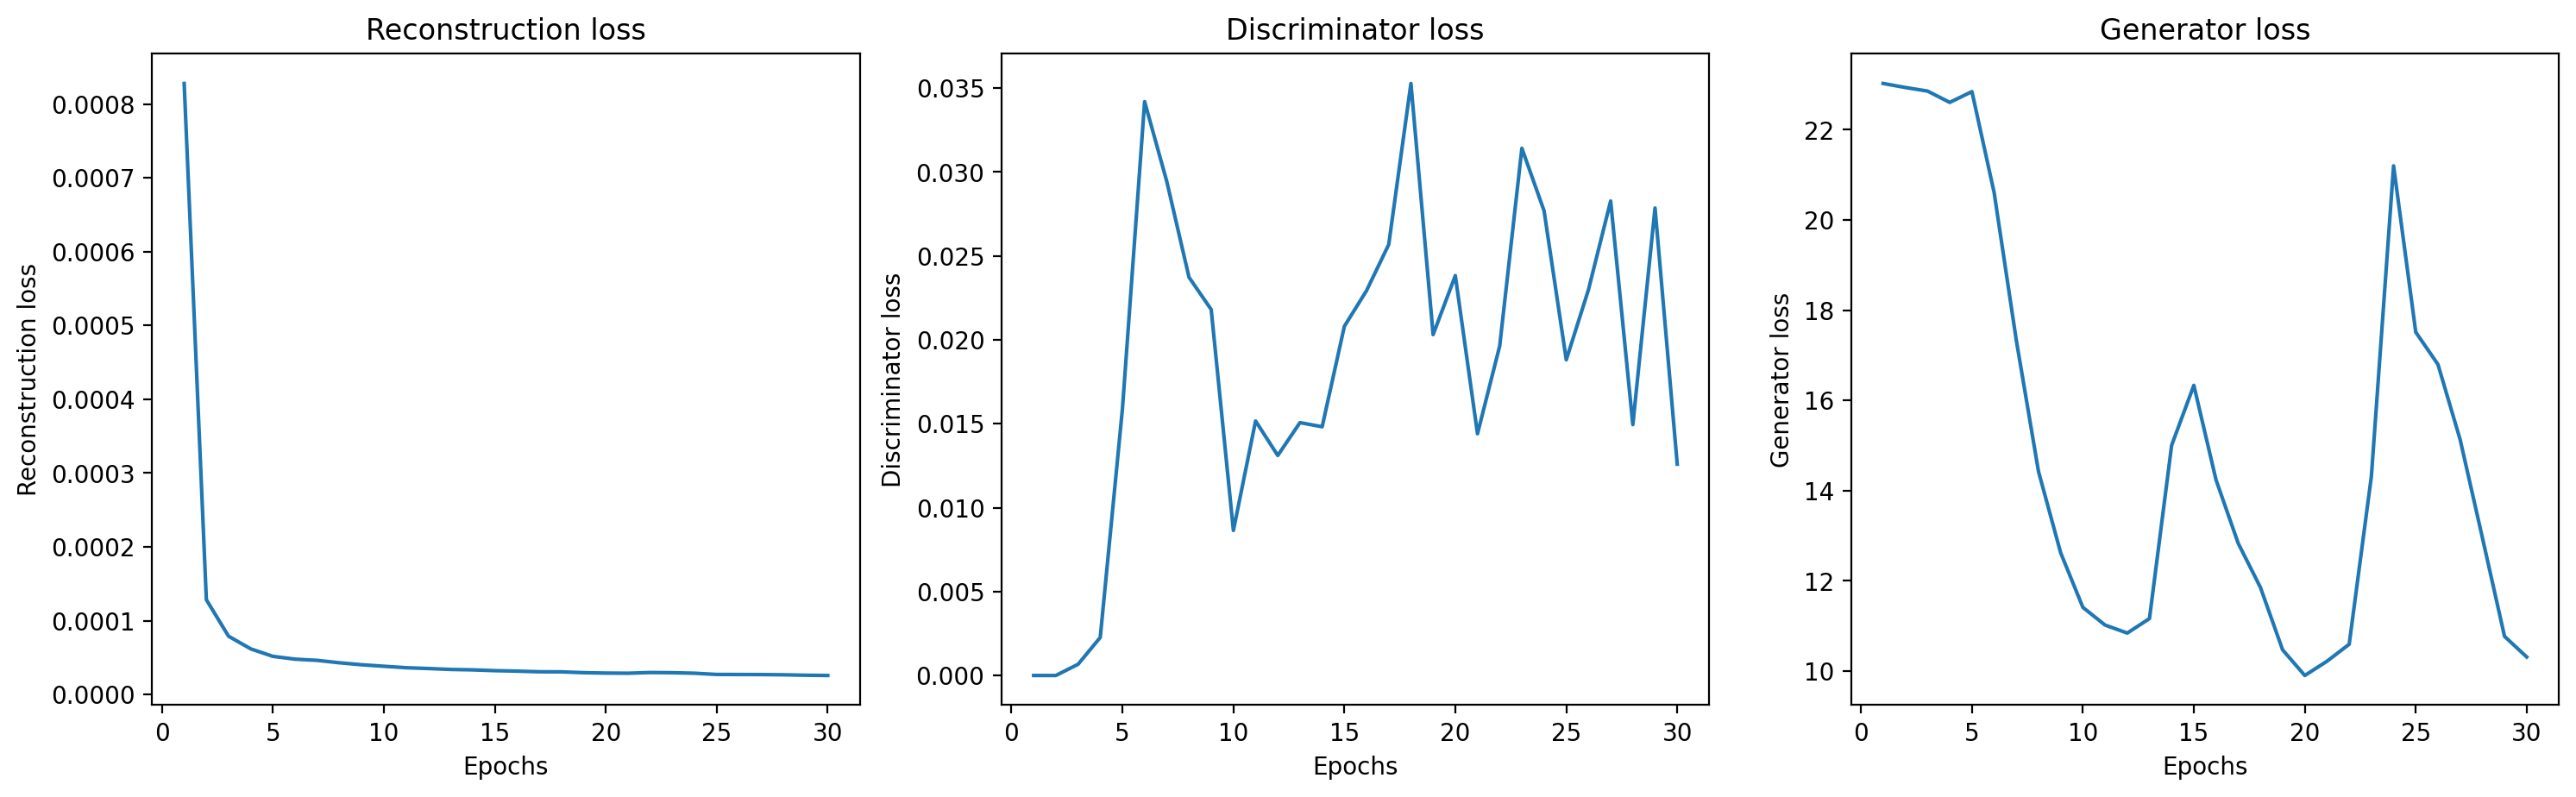

In [16]:
#aae.load_weights_and_history(save_path)
aae.metrics()

## 3.4 Evaluating `UnsupervisedAAE`

Finally, we can evaluate `UnsupervisedAAE` on the testing set by calling the `evaluate` method and passing as arguments the `test_dataloader`, a threshold `thresh` and a `find_thresh` boolean. This will output a ROC curve. With some small modifications to the input we could make it possible to classify an individual image!

The main idea for the classification aspect is the following: we get the image we want to evaluate, we encode it into a latent vector and then we decode it. We then compare the input image to the decoded image. If the difference between is below a certain threshold `thresh`, then the input image is like one of the images used for training (not an anomaly). If this difference is above `thresh`, then the input image is considered an anomaly.

`find_thresh` is a method that enables the program to automatically search for an appropriete `thresh` value. It is not recommendend though, as this threshold is a hyperparameter that should be fixed. This method is by all means conceptually **WRONG**, because it uses the testing set to tune an important part of the model. A more viable alternative would be to set `thresh` according to a validation set and keep it fixed.

  0%|          | 0/157 [00:00<?, ?it/s]


finding anomaly_scores statistics... use this to define `thresh`!


  0%|          | 0/157 [00:00<?, ?it/s]


LABEL 0: min: 6.750916327291634e-06 max: 5.3522428061114624e-05 mean: 1.8559566876501777e-05

LABEL 1: min: 9.457875421503559e-06 max: 7.550114241894335e-05 mean: 2.2273849774501286e-05

evaluating with thresh=2.0416708325501533e-05...


100%|██████████| 157/157 [00:31<00:00,  5.02it/s]


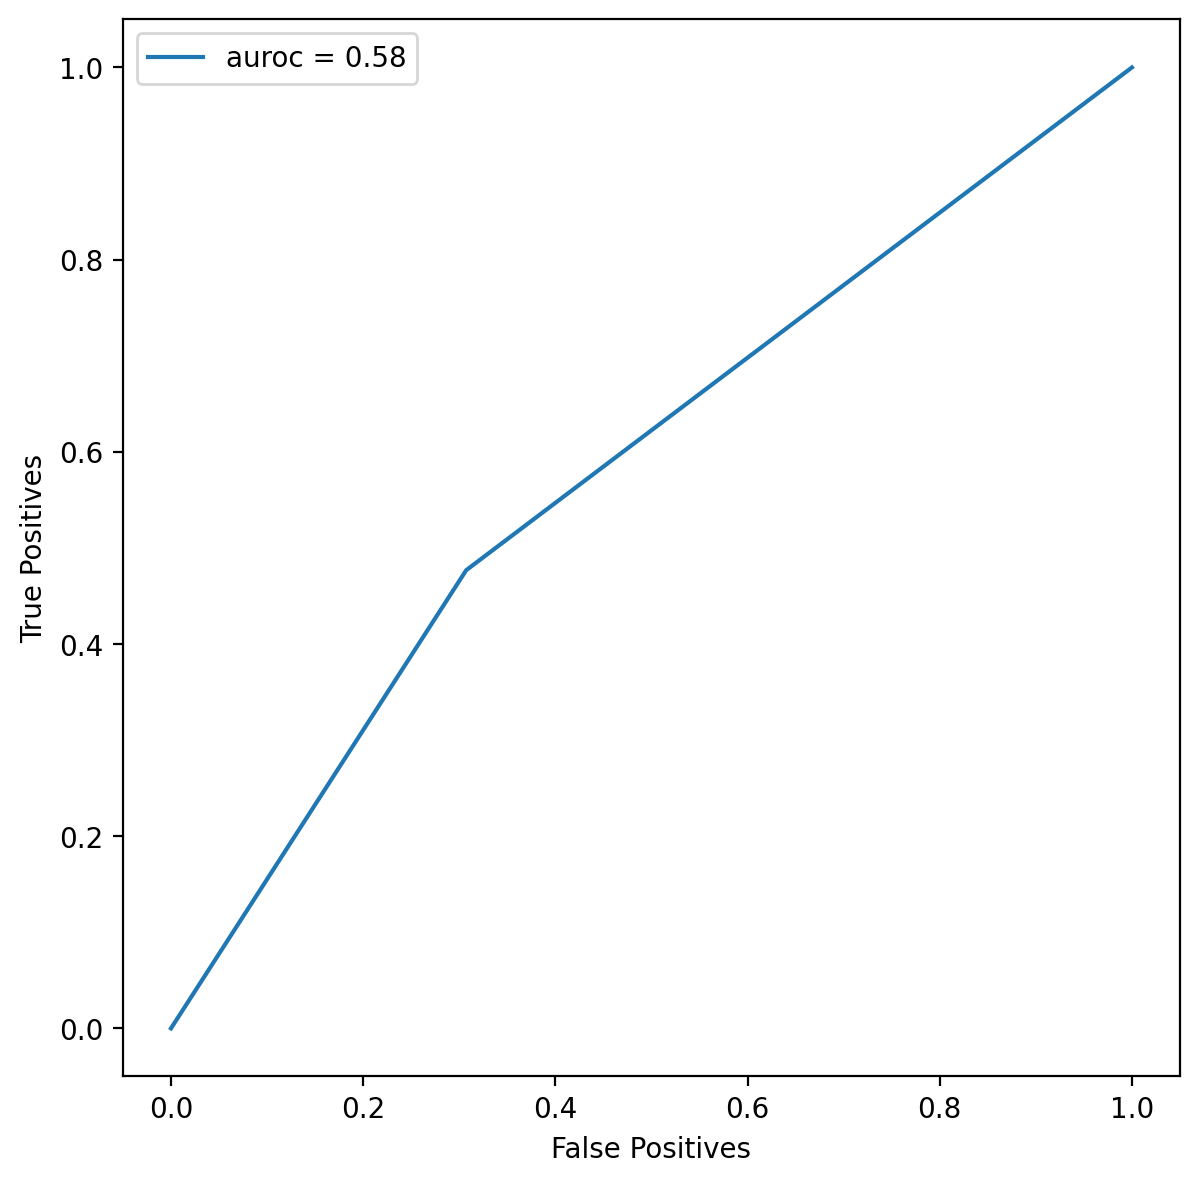

In [17]:
aae.evaluate(test_dataloader, 0.5, True)

# 4. How the AAE works

## 4.1 What is an AAE?

The structure of the AAE can be seen in the following picture, taken from [here](https://arxiv.org/pdf/1511.05644.pdf):

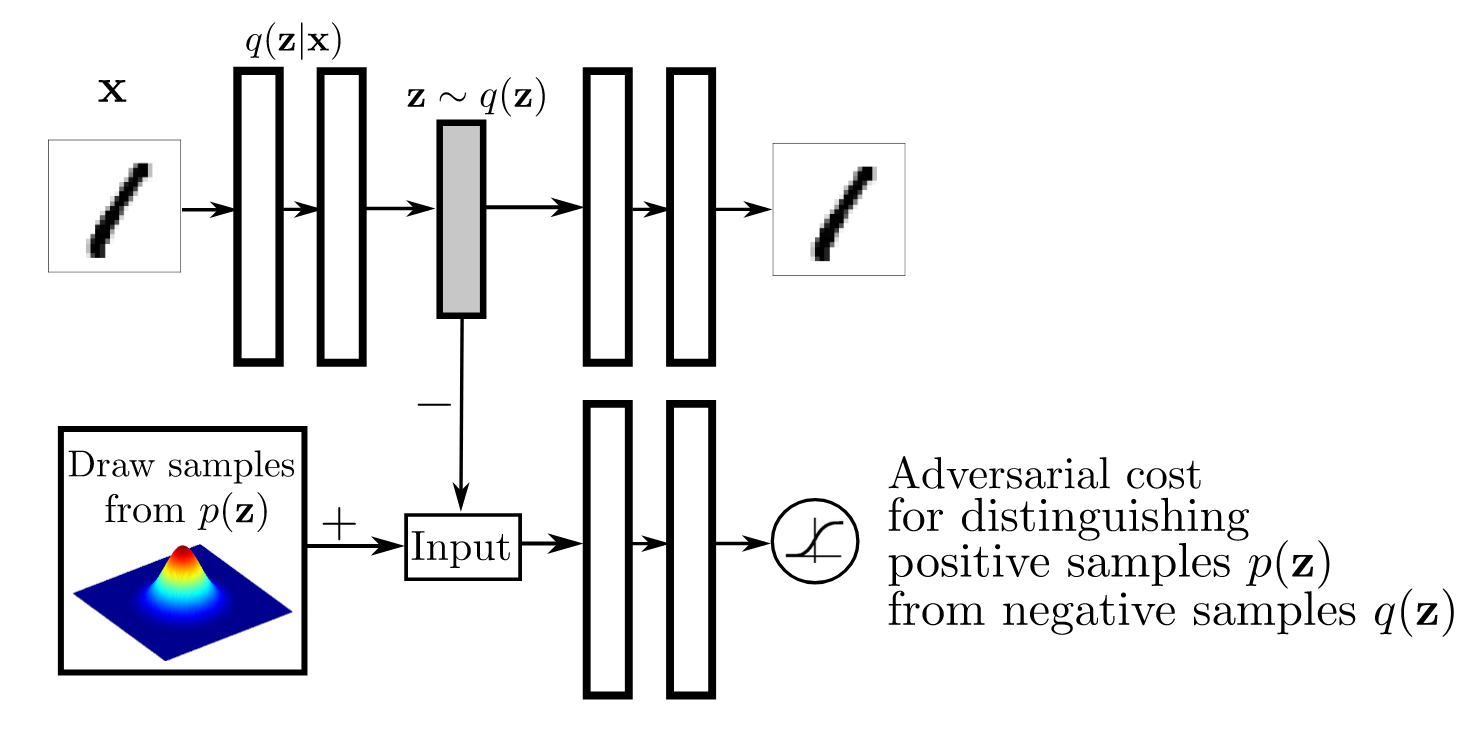



We have three main components: the `Encoder` ($q(z|x)$), the `Decoder` (upper right) and the `Discriminator` (bottom row).

The encoder receives as input an image $x$ and creates a latent representation of it, with smaller dimensions, similar to a compression operation. In our case, the input image $x$ has size 150x150x3, and it is transformed to a latent vector of size 1000x1x1: this is 67.5 times less information than the original image!!!

The decoder's job is to take this latent representation and reconstruct the input. Ideally, this reconstruction would be as close as possible to the input image $x$.

We want to create a latent space that follows a certain distriibution $p(z)$. so that we can generate new inputs without nedding to give the actual images. This makes it possible to "travel" around the latent space, exploring what's between the images that we used for training.

To do this, we make use of the discriminator. It is important to note that if we want to create a distribution for our latent space, we must teach the model to encode images according to this distribution. So we draw samples from our ideal ("real") distribution, which in our case is a simple Gaussian, and compare it with the latent vector of the image. The discriminator identifies which distribution is real and which is fake (random distribution that our encoder generated). From this, we can update the encoder to create vectors that follow our ideal distribution.

## 4.2 Creating an imposed distribution

This will be the kind of distribution we want our VAE to follow:

True


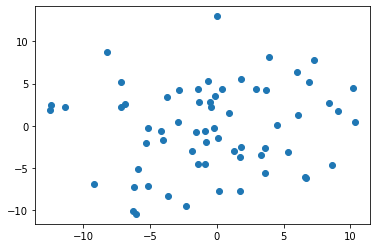

In [ ]:
z_distribution = torch.randn(BATCH_SIZE, 1000) * 5.
plt.scatter(z_distribution[:,0], z_distribution[:,1])
plt.show()

We could define any other kind of distribution, but this is the type that I've seen being used in other implementations, so it's the one I'm using.

Notice how the distribution has size 1000. This is because it must have the same size as our latent vector, which has a hard coded size of 1000.

## 4.3 Visualizing a sample output :)

The following cell of code is from an earlier prototype of how I was constructing the AAE. 

In the images we can see the AAE before being trained, just having their pre-trained models loaded in. It is important to note that I was experimenting with normalizing the data in different ways, which might explain why the images don't look so good, since I didn't know if the original models were trained with any sort of normalization.

The images on the left are the original input images, while images on the right are the same images as the ones on the left, but after being encoded and decoded. We can notice that even with two very different original images, both reconstructions are almost the same image!

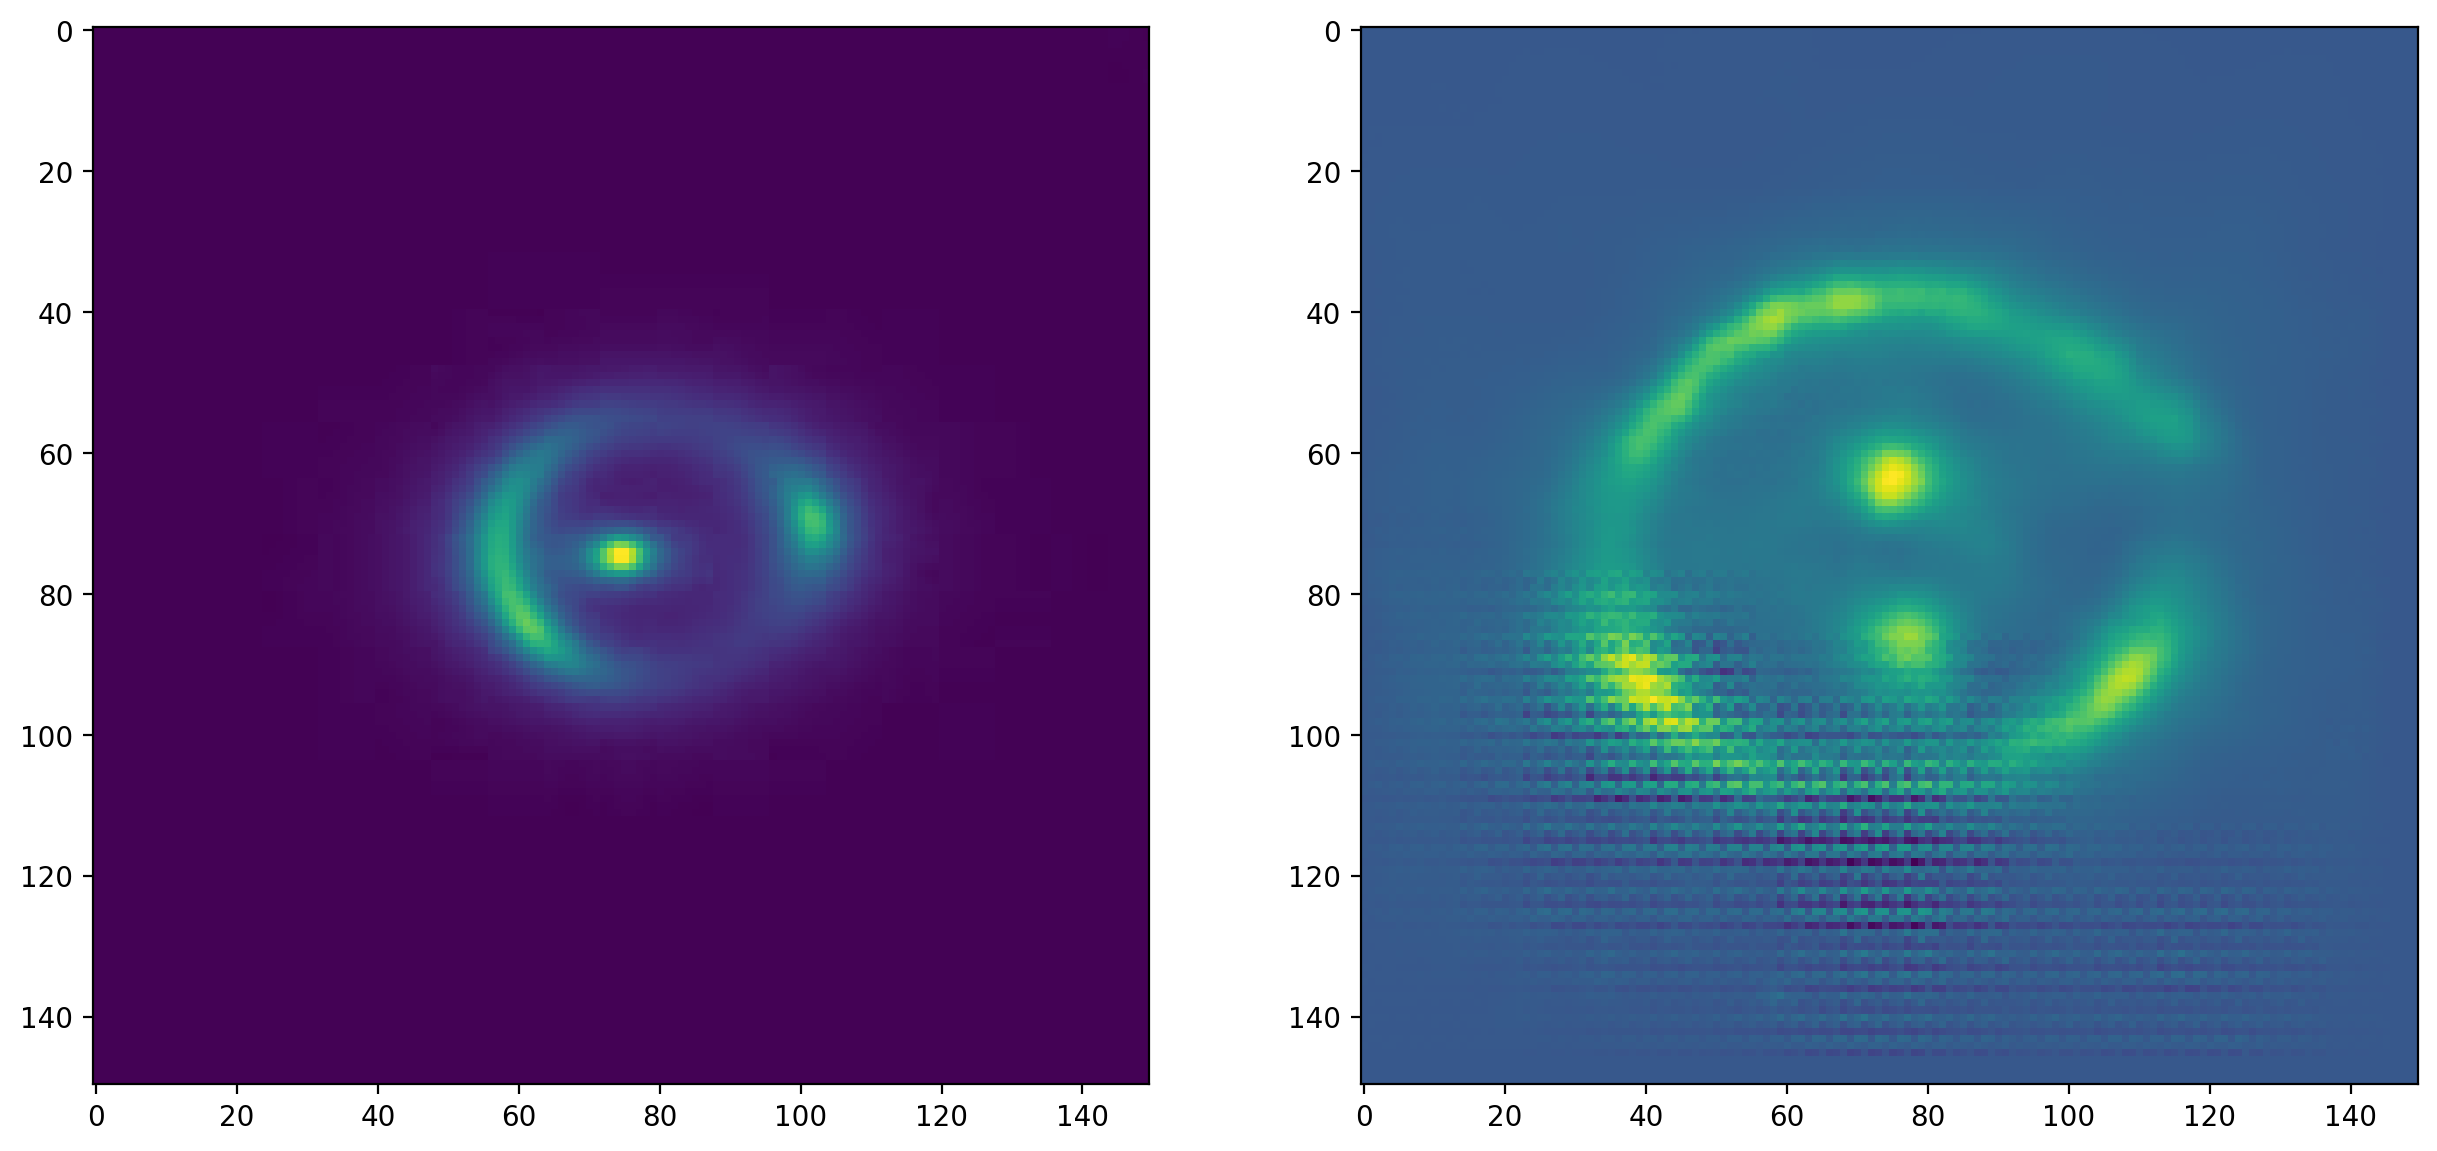

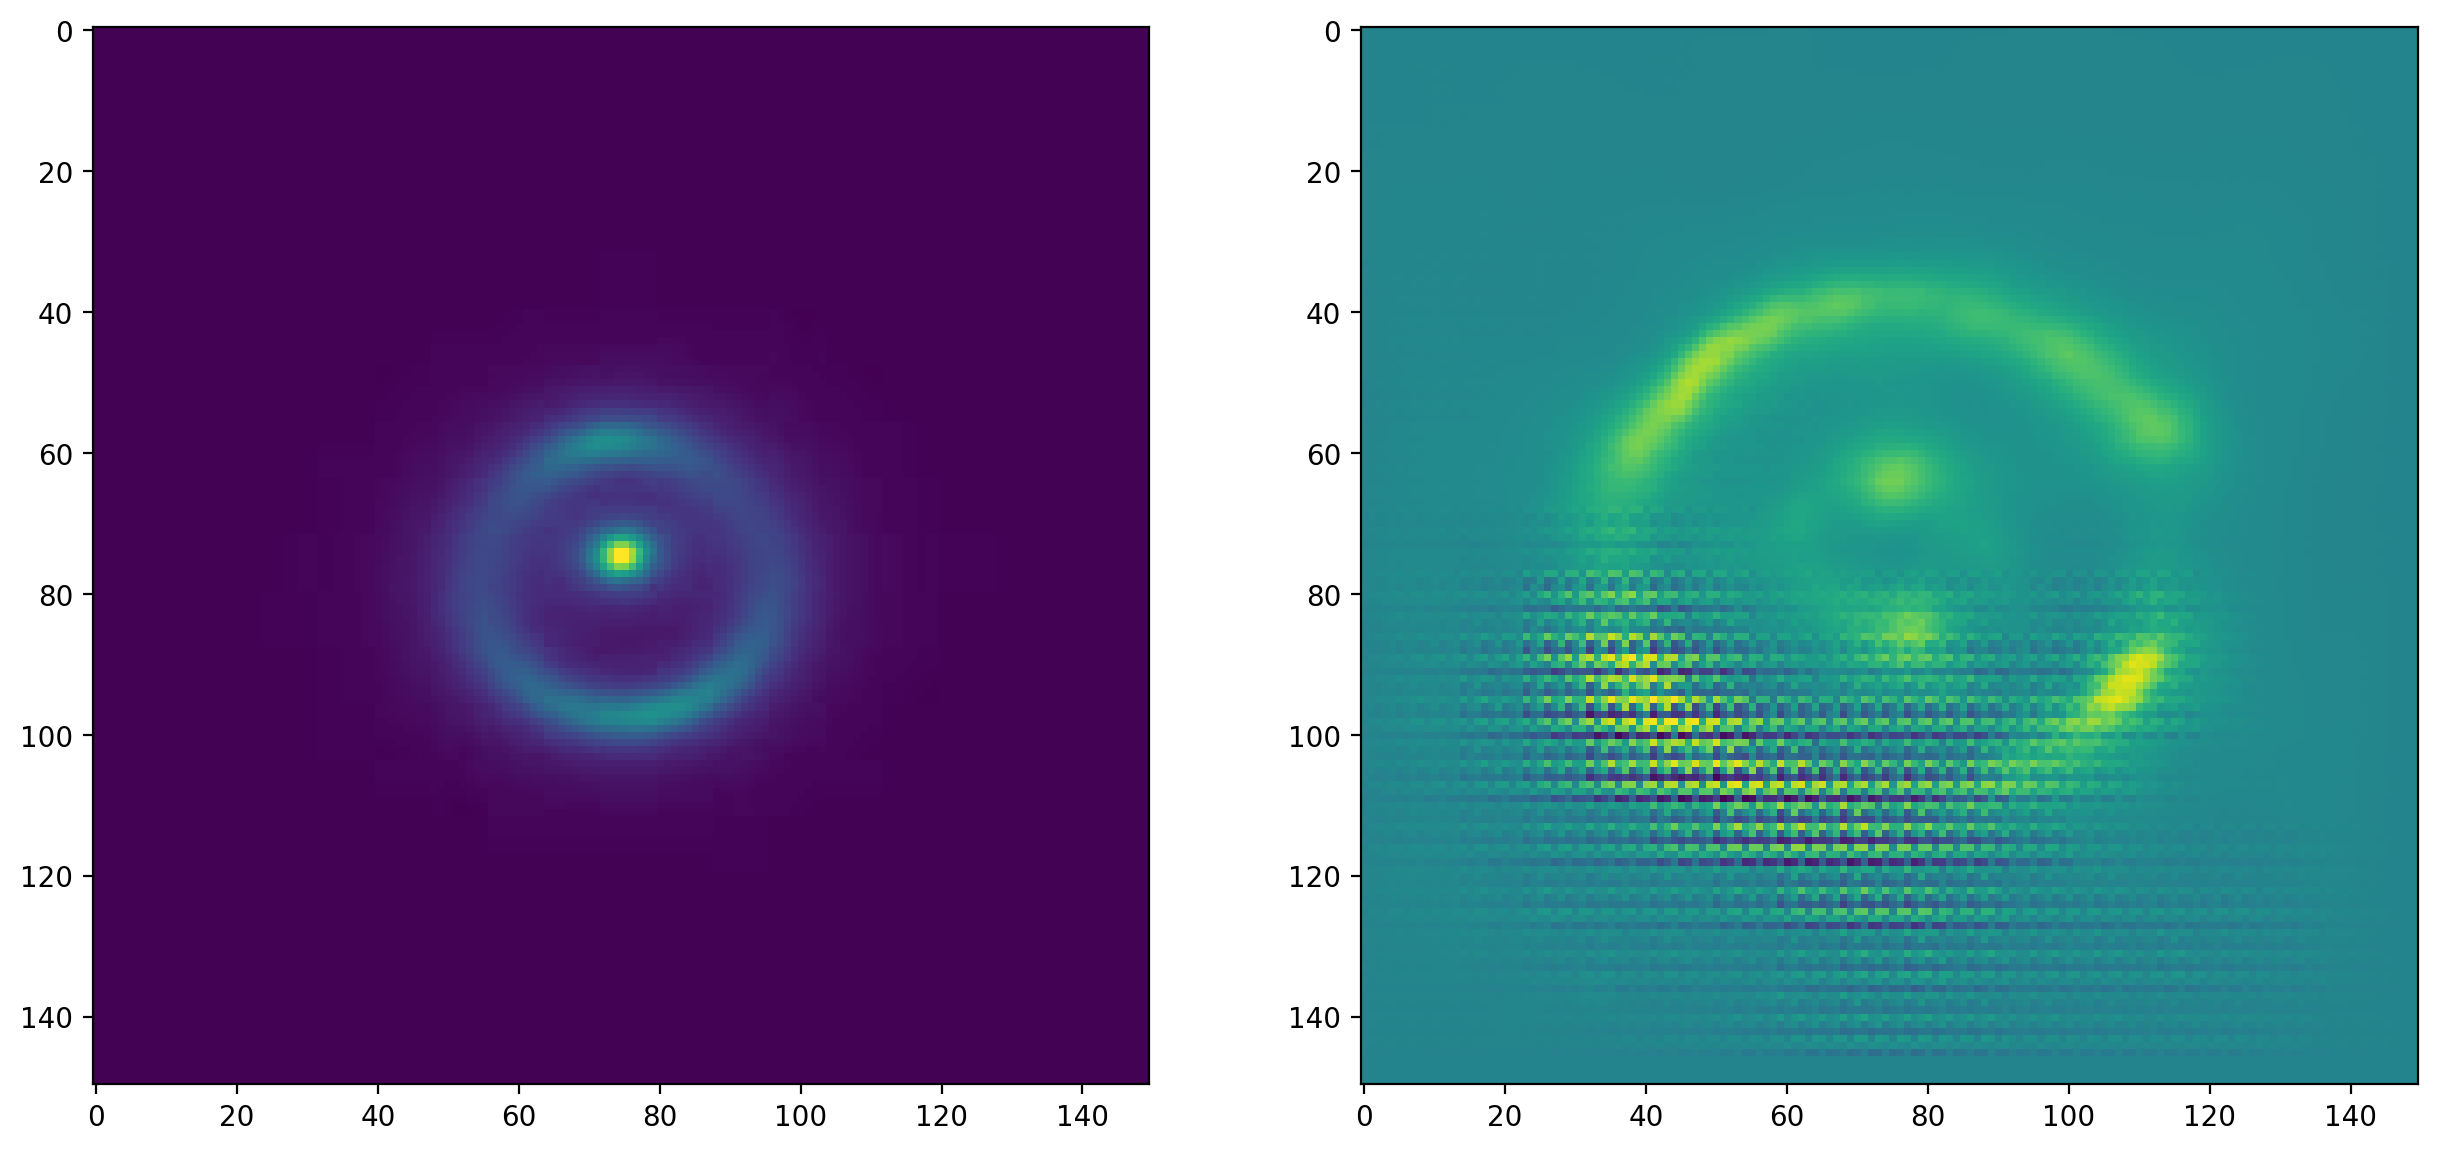

In [ ]:
for data, _ in test_dataloader:
    data = data.to(device)
    
    G = encoder(data)
    D = decoder(G)

    break

fig, axs = plt.subplots(1, 2, figsize=(15,7), dpi=200)
axs[0].imshow(data[0][0].cpu())
axs[1].imshow(D[0][0].detach().cpu())
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15,7), dpi=200)
axs[0].imshow(data[63][0].cpu())
axs[1].imshow(D[63][0].detach().cpu())
plt.show()

## 4.4 How do I use this for classification?

In the final `UnsupervisedAAE`, I apply a simple mean squared error comparing the original image to the generated one. This outputs an anomaly score. If the anomaly score is above a certain threshold, the image is considered an anomaly.

This was inspired heavily by [this](https://arxiv.org/pdf/1902.06924.pdf) paper. It is important to note that they mention the use of applying the discriminator to the encoded data and using this as an anomaly score. I didn't apply this method because it didn't seem to output good results for me, but maybe it's because I tested it with only a few training epochs.

# REFERENCES:

- https://arxiv.org/pdf/1908.00734.pdf
- https://arxiv.org/pdf/2008.12731.pdf
- https://arxiv.org/pdf/1902.06924.pdf
- https://github.com/fducau/AAE_pytorch
- https://towardsdatascience.com/a-wizards-guide-to-adversarial-autoencoders-part-2-exploring-latent-space-with-adversarial-2d53a6f8a4f9
- https://blog.paperspace.com/adversarial-autoencoders-with-pytorch/
- https://github.com/bfarzin/pytorch_aae
- https://github.com/sksq96/pytorch-vae
- https://github.com/neale/Adversarial-Autoencoder
- https://github.com/shaharazulay/adversarial-autoencoder-classifier